# Phase 4 Project - NLP

#### Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, words, wordnet
import string
nltk.download('words')
nltk.download('stopwords', quiet=True)
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('tagsets')
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix, precision_score, classification_report

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package words to
[nltk_data]     /Users/leahschell/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/leahschell/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/leahschell/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


#### Data Exploration

In [2]:
df = pd.read_csv('data/tweets.csv', encoding='utf8')

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
#View the whole tweet
#df.style.set_properties(**{'text-align': 'left'})
#Locating single tweets to view all text
#df['tweet_text'].iloc[2000]

In [5]:
df.shape

(9093, 3)

In [6]:
#rename columns
df.set_axis(['tweet', 'directed', 'emotion'], axis=1, inplace=True)
df.head()

,tweet,directed,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [7]:
#df.style.set_properties(**{'text-align': 'left'})

In [8]:
#Drop one missing tweet
df.dropna(subset='tweet', axis=0, inplace=True)

In [9]:
df['directed'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: directed, dtype: int64

In [10]:
#Drop non-apple values in Directed to column
#Come back to this to make cleaner later??

df = df[(df['directed'] != 'Android App') & (df['directed'] != 'Android') & (df['directed'] != 'Google') & (df['directed'] != 'Other Google product or service')]

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

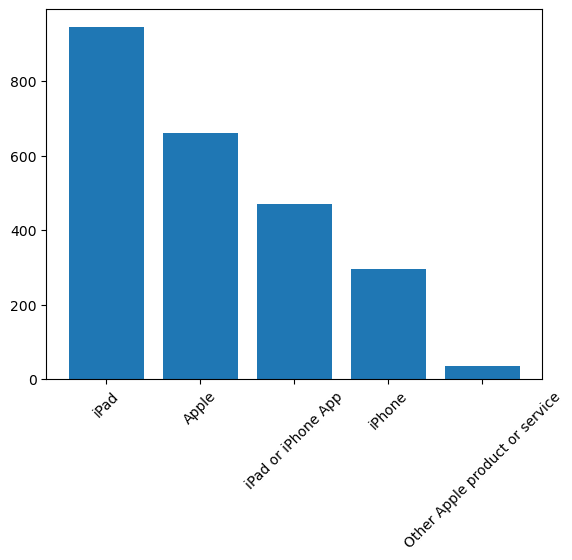

In [11]:
plt.bar(df['directed'].value_counts().index, df['directed'].value_counts().values)
plt.xticks(rotation=45)

In [12]:
df['tweet'] = df['tweet'].str.lower()

Create dataframe for only NaN values in Directed column

In [13]:
d_nan = df[(df['directed'].isna())]

Iterate through rows and fill the NaN values with a string from the tweet based on the product

In [14]:
for index, row in d_nan.iterrows():
    if 'apple' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'Apple'
    elif 'iphone' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'iPhone'
    elif 'ipad' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'iPad'
    elif 'steve jobs' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'Apple'
    elif 'stevejobs' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'Apple'
    else:
        pass

In [15]:
##Not all located the string

d_nan.isna().sum()

tweet          0
directed    2682
emotion        0
dtype: int64

In [16]:
#Dropping Nulls from the original dataframe
dfdrop = df.dropna(subset='directed', axis=0)

In [17]:
#Concat original dataframe with imputed dataframe
df_join = pd.concat([d_nan, dfdrop])

In [18]:
#Drop leftover missing values and rename to original dataframe name - 'df'
df = df_join.dropna(axis=0)

Encoding Emotion column

In [19]:
df = df[(df['emotion'] != "I can't tell")]
df['emotion'].value_counts()

No emotion toward brand or product    2876
Positive emotion                      2135
Negative emotion                       418
Name: emotion, dtype: int64

In [20]:
emo_dict = {'No emotion toward brand or product': 1, 'Positive emotion': 2, 'Negative emotion': 0}
df['emotion'] = df['emotion'].map(emo_dict)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5429 entries, 5 to 9088
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     5429 non-null   object
 1   directed  5429 non-null   object
 2   emotion   5429 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 169.7+ KB


In [22]:
df['tweet'].str.contains('japan').any()

True

In [23]:
df['tweet'].str.contains('japan').sum()

88

In [24]:
df = df.drop(df[df.apply(lambda row: row.astype(str).str.contains('japan').any(), axis=1)].index)
df.shape

(5341, 3)

## Preprocessing

#### TrainTestSplit

In [25]:
X = pd.DataFrame(df['tweet'])
y = pd.DataFrame(df['emotion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Preprocess train

#### Tokenize

In [26]:
pattern = r"(?u)\b\w\w+\b" ## tentative pattern, may need to look into better options. This gets rid of punctuation
tokenizer = RegexpTokenizer(pattern)
#'a-zA-Z0-9'

In [27]:
X_train['tweet'] = X_train['tweet'].apply(tokenizer.tokenize)

#### Remove stopwords

In [28]:
stoplist = stopwords.words('english')

In [29]:
def remove_stops(tweet):
    tweet = [x for x in tweet if x not in stoplist]
    return tweet

In [30]:
X_train['tweet'] = X_train['tweet'].apply(remove_stops)

In [31]:
X_train['tweet']

5292    [rt, mention, sxsw, go, available, platforms, ...
472     [even, begins, apple, wins, sxsw, link, via, m...
7548    [sxsw, csr, reporting, janecek, microsoft, giv...
7123    [waiting, sxsw, session, start, touching, stor...
6436    [rt, mention, part, journalsim, support, democ...
                              ...                        
2840    [picked, leanstartup, bundle, sxsw, mention, l...
8547    [mention, temp, store, 6th, amp, congress, sxs...
3598    [ridiculous, see, someone, taking, photo, sess...
866     [technews, man, panhandling, ipad, sxsw, ыєs, ...
8422    [mention, apple, sxsw, popupstore, like, crack...
Name: tweet, Length: 4005, dtype: object

#### Lemmetization

In [32]:
lem = WordNetLemmatizer()

In [33]:
    def get_wordnet_pos(tweet):
        
        tagged_tweet = pos_tag(tweet)
        
        new_tags = []
        for word, tag in tagged_tweet:
            if tag.startswith('J'):
                tag = wordnet.ADJ
                new_tags.append([word, tag])
            elif tag.startswith('V'):
                tag = wordnet.VERB
                new_tags.append([word, tag])
            elif tag.startswith('N'):
                tag = wordnet.NOUN
                new_tags.append([word, tag])
            elif tag.startswith('R'):
                tag = wordnet.ADV
                new_tags.append([word, tag])
            else:
                tag = wordnet.NOUN
                new_tags.append([word, tag])
                
        
        return new_tags

In [34]:
def lemma(tweet):
    tagged_tweet = get_wordnet_pos(tweet)
    tweet_lemmed = [lem.lemmatize(token[0], token[1]) for token in tagged_tweet]
    return tweet_lemmed

#Test to see if the lemmatization worked
print(X_train['tweet'][8])
lemma(X_train['tweet'][8])

['beautifully', 'smart', 'simple', 'idea', 'rt', 'madebymany', 'thenextweb', 'wrote', 'hollergram', 'ipad', 'app', 'sxsw', 'http', 'bit', 'ly', 'ieavob']


['beautifully',
 'smart',
 'simple',
 'idea',
 'rt',
 'madebymany',
 'thenextweb',
 'write',
 'hollergram',
 'ipad',
 'app',
 'sxsw',
 'http',
 'bit',
 'ly',
 'ieavob']

In [35]:
X_train['tweet'] = X_train['tweet'].apply(lemma) 

#### Remove rare words and frequent words

Words common in tweets that are not related to the sentiment (@mentions, links, etc)

In [36]:
word_count = Counter()

for tweet in X_train['tweet']:
    for token in tweet:
        word_count[token] += 1
        


In [37]:
word_count.most_common()[:200]

[('sxsw', 4319),
 ('mention', 2870),
 ('ipad', 1783),
 ('link', 1705),
 ('apple', 1703),
 ('rt', 1228),
 ('iphone', 1147),
 ('store', 1090),
 ('quot', 604),
 ('austin', 591),
 ('app', 464),
 ('pop', 426),
 ('open', 371),
 ('get', 370),
 ('new', 362),
 ('ipad2', 342),
 ('amp', 327),
 ('line', 318),
 ('go', 267),
 ('one', 207),
 ('win', 202),
 ('temporary', 198),
 ('launch', 186),
 ('via', 174),
 ('come', 163),
 ('downtown', 160),
 ('design', 157),
 ('popup', 153),
 ('like', 152),
 ('android', 146),
 ('day', 140),
 ('free', 138),
 ('use', 136),
 ('see', 135),
 ('sxswi', 132),
 ('make', 130),
 ('time', 127),
 ('apps', 123),
 ('people', 118),
 ('look', 117),
 ('set', 113),
 ('check', 112),
 ('know', 109),
 ('take', 109),
 ('need', 108),
 ('today', 107),
 ('give', 101),
 ('guy', 98),
 ('shop', 97),
 ('buy', 93),
 ('wait', 92),
 ('want', 90),
 ('case', 90),
 ('show', 89),
 ('mobile', 88),
 ('cool', 87),
 ('sell', 86),
 ('think', 85),
 ('rumor', 84),
 ('first', 83),
 ('great', 81),
 ('next', 

In [38]:
removewords = ['sxsw', 'mention', 'rt', 'quot', 'link', 'sxswi', 'ып', 'ыќ']

In [39]:
def remove_words(tweet):
    tweet = [x for x in tweet if x not in removewords]
    return tweet

In [40]:
X_train['tweet'] = X_train['tweet'].apply(remove_words)

In [41]:
X_train

,tweet
5292,"[go, available, platform, iphone, ipad, androi..."
472,"[even, begin, apple, win, via]"
7548,"[csr, report, janecek, microsoft, give, charit..."
7123,"[wait, session, start, touch, story, design, d..."
6436,"[part, journalsim, support, democracy, yes, in..."
...,...
2840,"[pick, leanstartup, bundle, startup, read, ipad]"
8547,"[temp, store, 6th, amp, congress, attendee, ex..."
3598,"[ridiculous, see, someone, take, photo, sessio..."
866,"[technews, man, panhandle, ipad, ыєs, world, c..."


### Vectorization

Join tweets for vectorizing (TFIDF cant take tokens)

In [42]:
for i, row in X_train.iterrows():
    joined_tweet = " ".join(X_train['tweet'][i])
    X_train['tweet'][i] = joined_tweet  

In [43]:
#Test
X_train['tweet'][8]

'beautifully smart simple idea madebymany thenextweb write hollergram ipad app http bit ly ieavob'

In [44]:
tf = TfidfVectorizer(max_features=50)


X_train_vec = tf.fit_transform(X_train['tweet'])

In [45]:
X_train_vec

<4005x50 sparse matrix of type '<class 'numpy.float64'>'
	with 13641 stored elements in Compressed Sparse Row format>

In [46]:
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)

In [47]:
X_train_vec.columns = sorted(tf.vocabulary_)

In [48]:
X_train_vec.head()

,amp,android,app,apple,apps,austin,buy,case,check,come,...,store,take,temporary,time,today,use,via,wait,want,win
0,0.0,0.671824,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,0.0,0.000000,0.0,0.319290,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.677687,0.000000,0.0,0.662415
2,0.0,0.000000,0.0,0.198338,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.713475,0.0,0.000000
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [49]:
y_train.value_counts()

emotion
1          2108
2          1596
0           301
dtype: int64

### Preprocess Test

In [50]:
X_test['tweet'] = X_test['tweet'].apply(tokenizer.tokenize)

In [51]:
X_test['tweet'] = X_test['tweet'].apply(remove_stops)

In [52]:
X_test['tweet'] = X_test['tweet'].apply(lemma)

In [53]:
X_test['tweet'] = X_test['tweet'].apply(remove_words)

In [54]:
X_test

,tweet
8859,"[mashable, talk, line, taker, many, spend, goo..."
7275,"[anyone, know, hour, apple, store]"
8367,"[day, late, night, party, pack, 30, session, d..."
5993,"[hey, iphone, love, turn, art, iphone, case, l..."
5940,"[get, crave, mind, create, app, foodspotting, ..."
...,...
7910,"[mark, third, time, someone, ask, watch, ipad,..."
7682,"[cnngrill, celebrate, piday, pecan, apple, str..."
6140,"[ipad, people, brilliant, spider, secret, bryc..."
3322,"[gonna, get, ipad2, apple, store, today, bet, ..."


#### Vectorizing Test

In [55]:
for i, row in X_test.iterrows():
    joined_tweet = " ".join(X_test['tweet'][i])
    X_test['tweet'][i] = joined_tweet  

In [56]:
X_test_vec = tf.transform(X_test['tweet'])

# First Model - Decision Tree Classifier

In [57]:
dt = DecisionTreeClassifier(max_depth=3, random_state=1)

In [58]:
dt.fit(X_train_vec, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

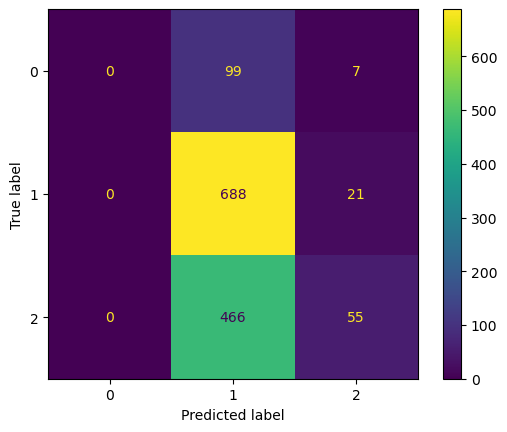

In [59]:
plot_confusion_matrix(dt, X_test_vec, y_test)

[Text(0.5769230769230769, 0.875, 'X[10] <= 0.43\ngini = 0.559\nsamples = 4005\nvalue = [301, 2108, 1596]'),
 Text(0.3076923076923077, 0.625, 'X[2] <= 0.569\ngini = 0.557\nsamples = 3921\nvalue = [300, 2099, 1522]'),
 Text(0.15384615384615385, 0.375, 'X[1] <= 0.138\ngini = 0.553\nsamples = 3769\nvalue = [283, 2053, 1433]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.557\nsamples = 3635\nvalue = [278, 1950, 1407]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.37\nsamples = 134\nvalue = [5, 103, 26]'),
 Text(0.46153846153846156, 0.375, 'X[2] <= 0.637\ngini = 0.553\nsamples = 152\nvalue = [17, 46, 89]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.257\nsamples = 33\nvalue = [0, 5, 28]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.598\nsamples = 119\nvalue = [17, 41, 61]'),
 Text(0.8461538461538461, 0.625, 'X[0] <= 0.19\ngini = 0.212\nsamples = 84\nvalue = [1, 9, 74]'),
 Text(0.7692307692307693, 0.375, 'X[35] <= 0.213\ngini = 0.178\nsamples = 82\nvalue = [1, 7, 74]'),
 Text(0.6923076923076

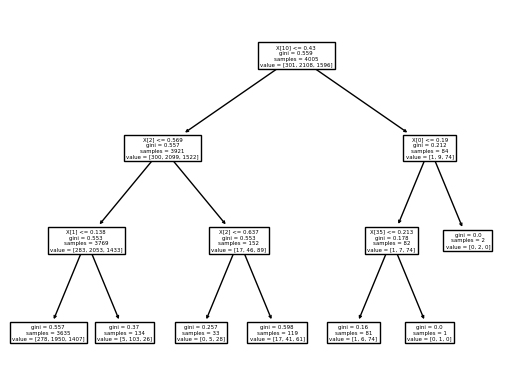

In [60]:
plot_tree(dt)

In [61]:
dt.score(X_test_vec, y_test)

0.5561377245508982

In [62]:
dt.score(X_train_vec, y_train)

0.5540574282147316

In [64]:
features=X_train_vec.columns.tolist()
important = dt.feature_importances_
important_features = pd.DataFrame(important, index=features, columns=['Important'])
important_features.sort_values('Important', ascending=False)

,Important
cool,0.494347
app,0.269907
android,0.167372
amp,0.045027
popup,0.023347
wait,0.000000
via,0.000000
mobile,0.000000
need,0.000000
new,0.000000


#### Interpretation

Most of the important words are the products/companies. We still have some cleaning to remove words that dont offer any sentiment. 

## Second round of preprocessing

In [65]:
#function that iterates over tweets
#returns a cleaned tweet in new col 
#does not contain words from a specified list

def clean_tweets(df, remove_list):
    clean_tweets = []
    for tweet in df['tweet']:
        words = tweet.split()
        clean_words = [x for x in words if x not in remove_list]
        clean_tweet = ' '.join(clean_words)
        clean_tweets.append(clean_tweet)
    df['clean_tweet'] = clean_tweets
    return df

In [66]:
remove2 = ['amp', 'via', 'android', 'app', 'apps', 'apple', 'iphone']

X_train2 = clean_tweets(X_train, remove2)
X_train2.head()

,tweet,clean_tweet
5292,go available platform iphone ipad android wind...,go available platform ipad window phone blackb...
472,even begin apple win via,even begin win
7548,csr report janecek microsoft give charity appl...,csr report janecek microsoft give charity give...
7123,wait session start touch story design digital ...,wait session start touch story design digital ...
6436,part journalsim support democracy yes inform p...,part journalsim support democracy yes inform p...


In [67]:
#clean X_test
X_test2 = clean_tweets(X_test,remove2)
X_test2.head()

,tweet,clean_tweet
8859,mashable talk line taker many spend good part ...,mashable talk line taker many spend good part ...
7275,anyone know hour apple store,anyone know hour store
8367,day late night party pack 30 session design ip...,day late night party pack 30 session design ip...
5993,hey iphone love turn art iphone case let u kno...,hey love turn art case let u know zazzlesxsw
5940,get crave mind create app foodspotting iphone ...,get crave mind create foodspotting


In [68]:
X_train2 = X_train2.drop(['tweet'], axis=1)

In [69]:
X_train2 = X_train2.rename(columns= {'clean_tweet': 'tweet'})
X_train2.head()

,tweet
5292,go available platform ipad window phone blackb...
472,even begin win
7548,csr report janecek microsoft give charity give...
7123,wait session start touch story design digital ...
6436,part journalsim support democracy yes inform p...


In [70]:
X_test2 = X_test2.drop(['tweet'], axis=1)
X_test2

,clean_tweet
8859,mashable talk line taker many spend good part ...
7275,anyone know hour store
8367,day late night party pack 30 session design ip...
5993,hey love turn art case let u know zazzlesxsw
5940,get crave mind create foodspotting
...,...
7910,mark third time someone ask watch ipad hit res...
7682,cnngrill celebrate piday pecan strawberry rhub...
6140,ipad people brilliant spider secret bryce mano...
3322,gonna get ipad2 store today bet que get big ip...


In [71]:
X_test2 = X_test2.rename(columns= {'clean_tweet': 'tweet'})
X_test2.head()

,tweet
8859,mashable talk line taker many spend good part ...
7275,anyone know hour store
8367,day late night party pack 30 session design ip...
5993,hey love turn art case let u know zazzlesxsw
5940,get crave mind create foodspotting


### vectorizing new x_train and x_test

In [72]:
tf2 = TfidfVectorizer(max_features=50)

X_train_vec2 = tf2.fit_transform(X_train2['tweet'])

In [73]:
X_train_vec2 = pd.DataFrame.sparse.from_spmatrix(X_train_vec2)
X_train_vec2.columns = sorted(tf2.vocabulary_)
X_train_vec2.head()

,austin,buy,case,check,come,cool,day,design,downtown,first,...,store,take,temporary,think,time,today,use,wait,want,win
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.643878,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.713475,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [74]:
X_test_vec2 = tf2.transform(X_test2['tweet'])
X_test_vec2 = pd.DataFrame.sparse.from_spmatrix(X_test_vec2)
X_test_vec2.columns = sorted(tf2.vocabulary_)
X_test_vec2.head()

,austin,buy,case,check,come,cool,day,design,downtown,first,...,store,take,temporary,think,time,today,use,wait,want,win
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.449576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.684363,0.670032,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.578136,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
tf2.vocabulary_

{'go': 13,
 'ipad': 16,
 'win': 49,
 'give': 12,
 'wait': 47,
 'design': 7,
 'time': 44,
 'open': 30,
 'temporary': 42,
 'store': 40,
 'think': 43,
 'people': 31,
 'need': 26,
 'know': 18,
 'want': 48,
 'one': 29,
 'take': 41,
 'check': 3,
 'austin': 0,
 'line': 21,
 'mobile': 25,
 'pop': 32,
 'get': 11,
 'new': 27,
 'guy': 15,
 'shop': 38,
 'ipad2': 17,
 'great': 14,
 'downtown': 8,
 'cool': 5,
 'set': 37,
 'come': 4,
 'day': 6,
 'free': 10,
 'popup': 33,
 'look': 22,
 'rumor': 34,
 'launch': 19,
 'show': 39,
 'like': 20,
 'see': 35,
 'buy': 1,
 'next': 28,
 'use': 46,
 'case': 2,
 'love': 23,
 'sell': 36,
 'make': 24,
 'first': 9,
 'today': 45}

### Decision Tree Classifier 2

In [88]:
#not really using 7 here for any purpose other than
#rachael did
dt2 = DecisionTreeClassifier(max_depth=7, random_state=1)

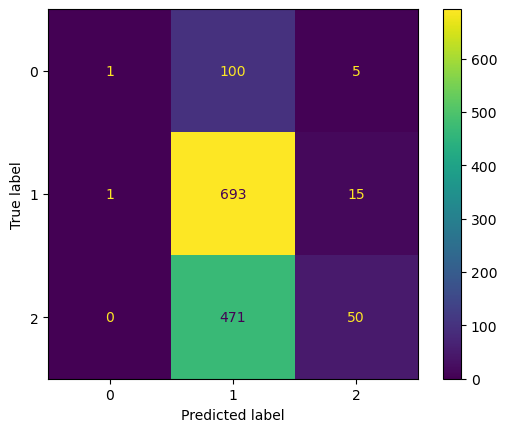

In [89]:
dt2.fit(X_train_vec2, y_train)
plot_confusion_matrix(dt2, X_test_vec2, y_test)

In [90]:
features2 = X_train_vec2.columns.tolist()
important2 = dt2.feature_importances_
important_features2 = pd.DataFrame(important2, index=features2, columns=['Important'])
important_features2.sort_values('Important', ascending=False)

,Important
cool,0.217672
great,0.140499
love,0.098991
mobile,0.078586
austin,0.067757
store,0.046870
design,0.045116
ipad2,0.037606
make,0.033605
buy,0.033010


In [91]:
#classification report
pred = dt.predict(X_test_vec)
pred2 = dt2.predict(X_test_vec2)
print ('\n clasification report 1:\n', classification_report(y_test,pred))
print ('\n clasification report 2:\n', classification_report(y_test,pred2))


 clasification report 1:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       106
           1       0.55      0.97      0.70       709
           2       0.66      0.11      0.18       521

    accuracy                           0.56      1336
   macro avg       0.40      0.36      0.29      1336
weighted avg       0.55      0.56      0.44      1336


 clasification report 2:
               precision    recall  f1-score   support

           0       0.50      0.01      0.02       106
           1       0.55      0.98      0.70       709
           2       0.71      0.10      0.17       521

    accuracy                           0.56      1336
   macro avg       0.59      0.36      0.30      1336
weighted avg       0.61      0.56      0.44      1336



In [87]:
y_train.value_counts()

emotion
1          2108
2          1596
0           301
dtype: int64